In [1]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix

## Download and preprocessing



In [2]:
mid_label_map = [
            (0,      'Other'),
            (406516, 'Open Door 1'),
            (406517, 'Open Door 2'),
            (404516, 'Close Door 1'),
            (404517, 'Close Door 2'),
            (406520, 'Open Fridge'),
            (404520, 'Close Fridge'),
            (406505, 'Open Dishwasher'),
            (404505, 'Close Dishwasher'),
            (406519, 'Open Drawer 1'),
            (404519, 'Close Drawer 1'),
            (406511, 'Open Drawer 2'),
            (404511, 'Close Drawer 2'),
            (406508, 'Open Drawer 3'),
            (404508, 'Close Drawer 3'),
            (408512, 'Clean Table'),
            (407521, 'Drink from Cup'),
            (405506, 'Toggle Switch')]
mid_label_to_id = {str(x[0]): i for i, x in enumerate(mid_label_map)}
mid_idToLabel = [x[1] for x in mid_label_map]

hi_label_map = [(0, 'Other'),
                (101, 'Relaxing'), (102, 'Coffee time'),
                (103, 'Early morning'), (104, 'Cleanup'),
                (105, 'Sandwich time')]

hi_label_to_id = {str(x[0]): i for i, x in enumerate(hi_label_map)}
hi_idToLabel = [x[1] for x in hi_label_map]

loco_map = [(0, 'Other'), (1 , 'Stand'), (2,'Walk'), (4, 'Sit'), (5, 'Lie')]
loco_label_to_id = {str(x[0]): i for i, x in enumerate(loco_map)}
loco_idToLabel = [x[1] for x in loco_map]

FEATURES = [str(i) for i in range(77)]
LOCO_LABEL_COL = 77
MID_LABEL_COL = 78
HI_LABEL_COL = 79
SUBJECT_ID = 80
RUN_ID = 81

In [18]:
# !wget -q -O ../data/clean_opp_nodrill.csv https://www.dropbox.com/s/uu4iz6lrzmssff8/clean_opp_nodrill.csv?dl=1

In [3]:
df = pd.read_csv('../data/clean_opp_nodrill.csv')

In [4]:
df.shape

(630676, 82)

### EDA

<AxesSubplot:>

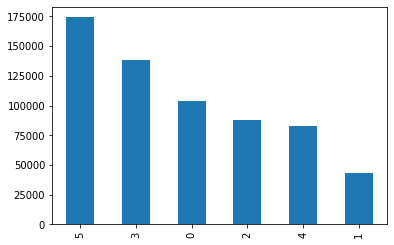

In [5]:
df.iloc[:, HI_LABEL_COL].value_counts().plot(kind='bar')

<AxesSubplot:>

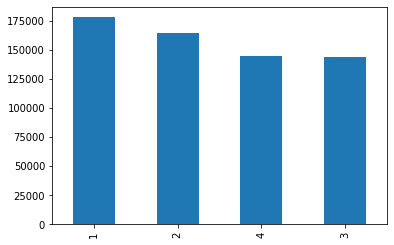

In [6]:
df.iloc[:, SUBJECT_ID].value_counts().plot(kind='bar')

### Imputation scaling

In [7]:
# Perform linear interpolation
df[FEATURES] = df[FEATURES].interpolate(method='linear', axis=0)

# Remaining missing data are converted to zero
df = df.fillna(0)

# All sensor channels are normalized
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

### train-test

In [8]:
BENCHMARK_TEST= ((df[str(SUBJECT_ID)] == 2) | (df[str(SUBJECT_ID)] == 3)) & ((df[str(RUN_ID)] == 4) | (df[str(RUN_ID)] == 5))

In [ ]:
train_df = df[~ BENCHMARK_TEST]
val_df =  df[BENCHMARK_TEST]
test_df = df[BENCHMARK_TEST]

### Window - session

In [9]:
SLIDING_WINDOW_LENGTH = 30*30
SLIDING_WINDOW_STEP = 30*5

In [11]:
def create_windowed_dataset(df, features= FEATURES, class_label = str(HI_LABEL_COL), window_size=24, stride = 12):
    X = df[features].values
    y = df[class_label].values
    segments = []
    labels = []
    seg_start= 0
    seg_end = window_size
    mid_labels = []
    loco_labels = []
    while seg_end <= len(X):
        if len(np.unique(y[seg_start:seg_end])) == 1: #valid-window
            segments.append(X[seg_start:seg_end])
            labels.append(y[seg_start]) # doesn't matter all same labels
            mid_labels.append(df[str(MID_LABEL_COL)].values[seg_start:seg_end])
            loco_labels.append(df[str(LOCO_LABEL_COL)].values[seg_start:seg_end])

            seg_start += stride
            seg_end = seg_start + window_size

        else: #mixed- discard last few samples, move start to the new activity
            current_label = y[seg_start]
            for i in range(seg_start, seg_end):
                if y[i] != current_label:
                    seg_start = i
                    seg_end = seg_start + window_size
                    break

    return np.asarray(segments).astype(np.float32), np.asarray(labels), mid_labels, loco_labels

In [12]:
X_train, y_train, m_labels_tr, loco_labels_tr = create_windowed_dataset(train_df, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)
X_val, y_val, m_labels_v, loco_labels_v = create_windowed_dataset(val_df, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)
X_test, y_test, m_labels_ts, loco_labels_ts = create_windowed_dataset(test_df, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)

NameError: name 'train_df' is not defined

In [ ]:
pd.Series(y_train).value_counts()

5    820
3    669
2    403
0    369
4    364
1     60
dtype: int64

In [ ]:
np.save('opp_benm_labels.npy', y_test)

In [ ]:
np.save('opp_benm_mid_l.npy', np.array(m_labels_ts))

In [ ]:
np.save('opp_benm_loco_l.npy', np.array(loco_labels_ts))

In [ ]:
print(mid_idToLabel)

['Other', 'Open Door 1', 'Open Door 2', 'Close Door 1', 'Close Door 2', 'Open Fridge', 'Close Fridge', 'Open Dishwasher', 'Close Dishwasher', 'Open Drawer 1', 'Close Drawer 1', 'Open Drawer 2', 'Close Drawer 2', 'Open Drawer 3', 'Close Drawer 3', 'Clean Table', 'Drink from Cup', 'Toggle Switch']


In [ ]:
def plot_opp_midlevel(idx):
    print('Hi lavel activity: ', y_test[idx])
    plt.figure(figsize=(12,5))
    plt.scatter(np.linspace(0,30,num=900),m_labels_ts[idx], color='g',linewidth=0.5)
    plt.yticks(range(18),labels=mid_idToLabel)
    plt.grid(True, axis='y',  linestyle='--')
    plt.show()

In [ ]:
# plot_opp_midlevel(44)

In [ ]:
def plot_opp_locomotion(idx):
    plt.figure(figsize=(8,5))
    plt.scatter(np.linspace(0,30,num=900),loco_labels_ts[idx], color='g',linewidth=0.5)
    plt.yticks(range(5),labels=loco_idToLabel)
    plt.grid(True, axis='y',  linestyle='--')
    plt.show()

In [ ]:
# plot_opp_locomotion(44)

In [ ]:
# count = 1
# prev = y_train[0]
# for wndw in y_train:
#     if wndw != 0:
#         if wndw == prev:
#             count+=1
# #         else:
#             print(f'{hi_idToLabel[prev]} -  {count/32} seconds')
#             count=1
#         prev=wndw

In [ ]:
N_WINDOW = 36
N_TIMESTEP = 25

In [ ]:
X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, 77))
X_val = X_val.reshape((X_val.shape[0], N_WINDOW, N_TIMESTEP, 77))
X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, 77))

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(2685, 36, 25, 77)
(2685, 6)
(599, 36, 25, 77)
(599, 6)
(599, 36, 25, 77)
(599, 6)


## tf data

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 2048

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Attention Model

In [13]:
class AggregateAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(AggregateAttention, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.d_model = d_model
        self.query = self.add_weight("learned_query",
                                     shape=[1, 1, self.d_model],
                                     initializer=tf.keras.initializers.Orthogonal())  
    
    def call(self, v, k):
        batched_query = tf.tile(self.query, [tf.shape(v)[0],1,1])
        output, attention_weights = self.mha(v, k, batched_query, mask=None)
        output = tf.squeeze(output, axis=1)
        attention_weights = tf.squeeze(attention_weights, axis=2)
        return output, attention_weights

### Self Attention

In [14]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model, include_dropout=True, dropout_rate=0.2):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.include_dropout = include_dropout
        if include_dropout:
            self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, x):
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[:, :tf.shape(x)[1], :]
        if self.include_dropout:
            x = self.dropout(x)
        return x

In [15]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [16]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model,use_bias=False)
        self.wk = tf.keras.layers.Dense(d_model,use_bias=True)
        self.wv = tf.keras.layers.Dense(d_model,use_bias=True)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                        (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


In [17]:
class SelfAttentionBlock(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(SelfAttentionBlock, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [18]:
class CombinedSensorSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate, concat=True):
        super(CombinedSensorSelfAttention, self).__init__()
        self.concat = concat
        self.agr_attn = AggregateAttention(d_model, num_heads)
        self.ffn1 = point_wise_feed_forward_network(d_model, dff)
        self.ffn2 = point_wise_feed_forward_network(d_model, dff)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x):
        if self.concat:
            x = tf.concat(x, axis=1)
        x = self.ffn1(x)
        x, attn_score = self.agr_attn(x, x)
        x = self.dropout1(x)
        ffn_output = self.ffn2(x)  # (batch_size, d_model)
        ffn_output = self.dropout2(ffn_output)
        out = self.layernorm(ffn_output + x)  # (batch_size, d_model)
        return out, attn_score

In [19]:
class DataTransform(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super(DataTransform, self).__init__()
        # self.ln = tf.keras.layers.LayerNormalization()
        self.conv_1d = tf.keras.layers.Conv1D(d_model, 1, activation='relu')
    
    def call(self, x):
        # x = self.ln(x)
        x = self.conv_1d(x)
        return x

In [20]:
class ModalityEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_timesteps, d_model, num_heads, dff, num_sa_blocks=2, dropout_rate=0.1):
        super(ModalityEncoderBlock, self).__init__()
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.look_ahead_mask = create_look_ahead_mask(n_timesteps)
        self.data_transform = DataTransform(d_model)
        self.pe = PositionalEncoding(n_timesteps, d_model, dropout_rate=dropout_rate)
        self.num_sa_blocks = num_sa_blocks
        self.self_attn_blocks = [ SelfAttentionBlock(d_model, num_heads, dff, dropout_rate)
                                        for _ in range(self.num_sa_blocks)]
        # self.agr_attn = AttentionWithContext(return_attention=True)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        x = self.data_transform(x)
        x = self.pe(x)
        for i in range(self.num_sa_blocks):
            # x = self.self_attn_blocks[i](x, mask=self.look_ahead_mask)
            x = self.self_attn_blocks[i](x)
        return x


    def compute_output_shape(x, input_shape):
        return tf.TensorShape([input_shape[0], self.d_model])

In [21]:
def get_modality_encoder(modality_indices, n_timesteps, n_features,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    num_modality = len(modality_indices)-1
    inputs = tf.keras.layers.Input(shape=(n_timesteps,n_features,))
    attn_scores = []
    modality_outputs = []
    for i in range(num_modality):
            modality_x = inputs[:, :, modality_indices[i]:modality_indices[i+1] ]
            modality_x = ModalityEncoderBlock(n_timesteps=n_timesteps, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(modality_x)
            modality_outputs.append(modality_x)
    model = tf.keras.Model(inputs=inputs, outputs=modality_outputs)
    return model

In [22]:
class MultiWindowEncoder(tf.keras.layers.Layer):
    def __init__(self, modality_indices, n_window, n_timesteps, n_features, d_model, num_heads, dff, dropout_rate=0.1):
        super(MultiWindowEncoder, self).__init__()
        self.n_window = n_window
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.window_encoder = get_modality_encoder(modality_indices,n_timesteps=n_timesteps, n_features=n_features, d_model=d_model, num_heads = num_heads, dff=dff, dropout_rate=dropout_rate)
        self.combined_sensor_attn = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        feature_dim = tf.shape(x)[-1]
        x = tf.reshape(x, (-1, self.n_timesteps, feature_dim)) # all sessions in batch dim
        x = self.window_encoder(x)
        x, attn_scores = self.combined_sensor_attn(x)
        x = tf.reshape(x, (batch_size, -1, self.d_model))
        attn_scores = tf.reshape(attn_scores, (batch_size, -1, self.n_timesteps))
        return x, attn_scores

In [23]:
def get_modality_model_w_time_hierarchy(modality_indices,n_window, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    inputs = tf.keras.layers.Input(shape=(n_window, n_timesteps,n_features,))
    x, _ = MultiWindowEncoder(modality_indices, n_window, n_timesteps,n_features, d_model, num_heads, dff, dropout_rate=0.1) (inputs)
    x = ModalityEncoderBlock(n_timesteps=n_window, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(x)
    x, _ = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate, concat=False) (x)
    predictions = tf.keras.layers.Dense(n_outputs, activation='softmax') (x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    return model

## Training

In [ ]:
tf.keras.backend.clear_session()

n_window, n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
model = get_modality_model_w_time_hierarchy([0,9,18,27,36,45,61,77], n_window, n_timesteps, n_features, n_outputs, d_model=64, num_heads = 2, dff=256)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics='accuracy')
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 25, 77)]      0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 787200    
_________________________________________________________________
modality_encoder_block_7 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 82944     
_________________________________________________________________
dense_112 (Dense)            (None, 6)                 390       
Total params: 974,534
Trainable params: 974,534
Non-trainable params: 0
_________________________________________________________________


In [ ]:
verbose, epochs, batch_size = 1, 35, 128
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,verbose=1, mode='max')
# mcp_save = ModelCheckpoint('test_3_best.hdf5', save_best_only=True, monitor='val_acc', mode='max')
# reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4, mode='min')

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              verbose=verbose, validation_data=(X_val, y_val))

Epoch 1/35
21/21 [==============================] - 44s 2s/step - loss: 1.5780 - accuracy: 0.4045 - val_loss: 0.9741 - val_accuracy: 0.6828
Epoch 2/35
21/21 [==============================] - 41s 2s/step - loss: 1.0240 - accuracy: 0.6127 - val_loss: 0.8778 - val_accuracy: 0.7195
Epoch 3/35
21/21 [==============================] - 41s 2s/step - loss: 0.7755 - accuracy: 0.7181 - val_loss: 0.7514 - val_accuracy: 0.7245
Epoch 4/35
21/21 [==============================] - 40s 2s/step - loss: 0.6249 - accuracy: 0.7840 - val_loss: 0.6657 - val_accuracy: 0.7780
Epoch 5/35
21/21 [==============================] - 40s 2s/step - loss: 0.4957 - accuracy: 0.8331 - val_loss: 0.5080 - val_accuracy: 0.8063
Epoch 6/35
21/21 [==============================] - 41s 2s/step - loss: 0.4604 - accuracy: 0.8387 - val_loss: 0.6835 - val_accuracy: 0.8264
Epoch 7/35
21/21 [==============================] - 41s 2s/step - loss: 0.4168 - accuracy: 0.8574 - val_loss: 0.4352 - val_accuracy: 0.8548
Epoch 8/35
21/21 [==

In [ ]:
pred = model.predict(X_test, batch_size=128)

In [ ]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89        57
           1       1.00      0.85      0.92        26
           2       0.89      0.97      0.93        72
           3       0.91      0.97      0.94       146
           4       0.93      0.78      0.85        72
           5       0.94      0.96      0.95       226

    accuracy                           0.93       599
   macro avg       0.93      0.90      0.91       599
weighted avg       0.93      0.93      0.93       599



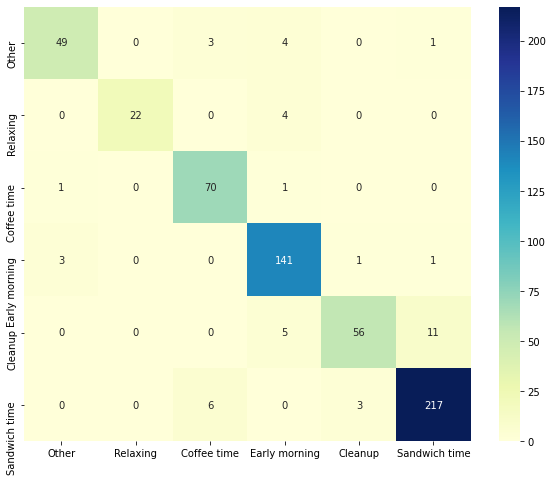

In [ ]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
activity_list = hi_idToLabel
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

### Leave out Experiment

In [27]:
def run_experiment(BATCH_SIZE =128, N_WINDOW = 36, N_TIMESTEP = 25, add_noise=False, no_null_class=False):

    full_sub = set(range(1,5))
    SHUFFLE_BUFFER_SIZE = 1024
    WINDOW_SIZE=30*30
    STRIDE=5*30
    for i in range(4, 0, -1):
        test_sub = set([i])
        train_sub = full_sub - test_sub
        print('test subjects', test_sub)
        print('train subjects', train_sub)
        df_temp = df.copy()
        if no_null_class:
            df_temp = df[df[str(HI_LABEL_COL)] != 0]
        train_df = df_temp[df_temp[str(SUBJECT_ID)] != i]
        test_df = df_temp[df_temp[str(SUBJECT_ID)] == i]

        if add_noise:
            df_aug = train_df.copy(deep=True)
            mu = 0.0
            sigma = 0.5
            for _ in range(4):
                noise = np.random.normal(mu, sigma, [train_df.shape[0], 77])
                df_noise = train_df[FEATURES].copy(deep=True)
                df_noise = df_noise + noise

                df_noise[str(SUBJECT_ID)] = train_df[str(SUBJECT_ID)]
                df_noise[str(HI_LABEL_COL)] = train_df[str(HI_LABEL_COL)]
                df_noise[str(LOCO_LABEL_COL)] = train_df[str(LOCO_LABEL_COL)]
                df_noise[str(MID_LABEL_COL)] = train_df[str(MID_LABEL_COL)]
                df_noise[str(RUN_ID)] = train_df[str(RUN_ID)]

                df_noise = df_noise[train_df.columns]
                df_aug = pd.concat([df_aug, df_noise], ignore_index=True)
            train_df = df_aug

        X_train, y_train, _ , _ = create_windowed_dataset(train_df, window_size=WINDOW_SIZE, stride = STRIDE)
        X_test, y_test, _ , _ = create_windowed_dataset(test_df, window_size=WINDOW_SIZE, stride = STRIDE)
        
        X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, 77))
        X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, 77))
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
        
        # device_list = ['/gpu:'+str(i) for i in range(3,5)]

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(4)
        test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(4)

        tf.keras.backend.clear_session()

        n_window, n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
        # Create a MirroredStrategy.
        # strategy = tf.distribute.MirroredStrategy(devices=device_list)
        # print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
        # with strategy.scope():
        model = get_modality_model_w_time_hierarchy([0,9,18,27,36,45,61,77], n_window, n_timesteps, n_features, n_outputs, d_model=64, num_heads = 2, dff=256)

        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics='accuracy')
        model.fit(train_dataset, epochs=60, verbose=2)

        pred = model.predict(test_dataset)
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1)))
        confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
        activity_list = hi_idToLabel
        if no_null_class:
            df_cm = pd.DataFrame(confm, index=activity_list[1:], columns=activity_list[1:])
        else:
            df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
        plt.figure(figsize = (10,8))
        sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
        plt.show()
        fig,ax =  plt.subplots(2,1, sharex=True)
        ax[0].plot(np.argmax(y_test, axis=1), label='true')
        ax[1].plot(np.argmax(pred, axis=1), label='pred')
        # plt.legend()
        plt.show()


test subjects {4}
train subjects {1, 2, 3}
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 3
Epoch 1/40
INFO:tensorflow:batch_all_reduce: 294 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 294 all-reduces with algorithm = nccl, num_packs = 1
37/37 - 41s - loss: 1.4718 - accuracy: 0.4493
Epoch 2/40
37/37 - 41s - loss: 0.7744 - accuracy: 0.7205
Epoch 3/40
37/37 - 41s - loss: 0.5288 - accuracy: 0.8118
Epoch 4/40
37/37 - 41s - loss: 0.4059 - accuracy: 0.8517
Epoch 5/40
37/37 - 41s - loss: 0.3490 - accuracy: 0.8732


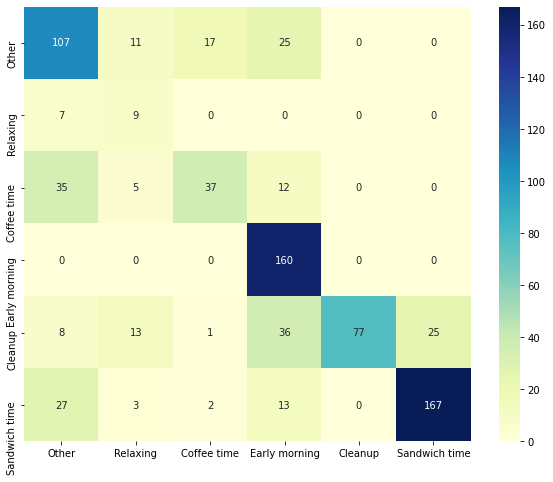

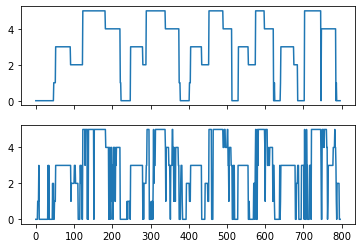

test subjects {3}
train subjects {1, 2, 4}
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 3
Epoch 1/40
INFO:tensorflow:batch_all_reduce: 294 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 294 all-reduces with algorithm = nccl, num_packs = 1
37/37 - 41s - loss: 1.6844 - accuracy: 0.3631
Epoch 2/40
37/37 - 41s - loss: 0.9382 - accuracy: 0.6531
Epoch 3/40
37/37 - 41s - loss: 0.6557 - accuracy: 0.7581
Epoch 4/40
37/37 - 41s - loss: 0.5057 - accuracy: 0.8163
Epoch 5/40
37/37 - 41s - loss: 0.4326 - accuracy: 0.8409
Epoch 6/40
37/37 - 41s - loss: 0.3671 - accuracy: 0.8659
Epoch 7/40
37/37 - 41s - loss: 0.3203 - accuracy: 0.8863
Epoch 8/40
37/37 - 41s - loss: 0.3155 - accuracy: 0.8850
Epoch 9/40
37/37 - 41s - loss: 0.2781 - accuracy: 0.9022
Epoch 10/40
37/37 - 41s - loss: 0.2262 - accuracy: 0

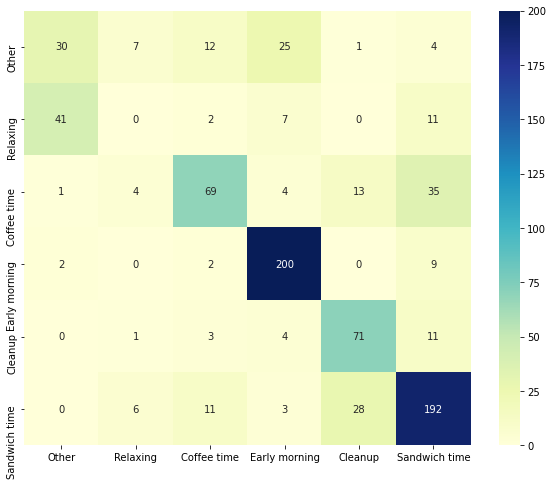

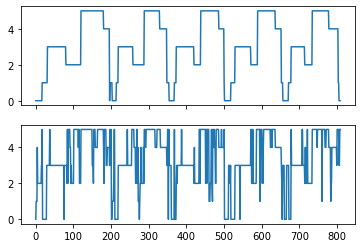

test subjects {2}
train subjects {1, 3, 4}
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 3
Epoch 1/40
INFO:tensorflow:batch_all_reduce: 294 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 294 all-reduces with algorithm = nccl, num_packs = 1
35/35 - 39s - loss: 1.5824 - accuracy: 0.3770
Epoch 2/40
35/35 - 39s - loss: 0.9063 - accuracy: 0.6610
Epoch 3/40
35/35 - 39s - loss: 0.5826 - accuracy: 0.7866
Epoch 4/40
35/35 - 39s - loss: 0.4562 - accuracy: 0.8367
Epoch 5/40
35/35 - 39s - loss: 0.3729 - accuracy: 0.8681
Epoch 6/40
35/35 - 39s - loss: 0.3011 - accuracy: 0.8959
Epoch 7/40
35/35 - 39s - loss: 0.2612 - accuracy: 0.9095
Epoch 8/40
35/35 - 39s - loss: 0.2255 - accuracy: 0.9230
Epoch 9/40
35/35 - 39s - loss: 0.2160 - accuracy: 0.9249
Epoch 10/40
35/35 - 39s - loss: 0.1809 - accuracy: 0

In [ ]:
#noise
run_experiment(BATCH_SIZE =128, N_WINDOW = 30, N_TIMESTEP = 20, add_noise=True)

test subjects {4}
train subjects {1, 2, 3}
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')
Number of devices: 2
INFO:tensorflow:batch_all_reduce: 294 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 294 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/ta

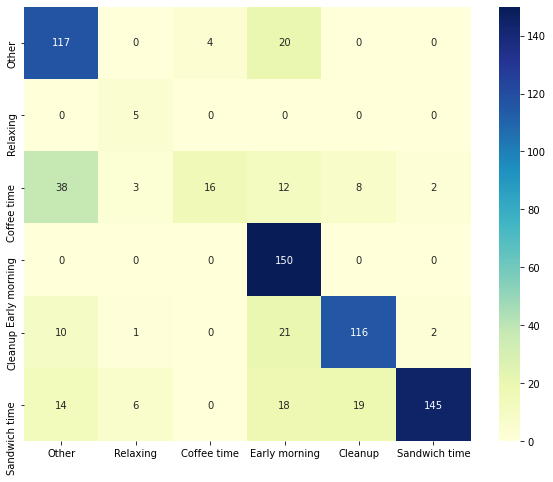

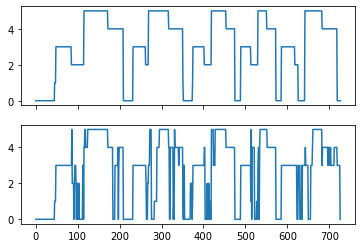

test subjects {3}
train subjects {1, 2, 4}
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')
Number of devices: 2
INFO:tensorflow:batch_all_reduce: 294 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 294 all-reduces with algorithm = nccl, num_packs = 1
              precision    recall  f1-score   support

           0       0.41      0.35      0.38        66
           1       0.92      0.29      0.44        42
           2       0.90      0.08      0.14       116
           3       0.76      0.96      0.85       203
           4       0.83      0.84      0.83        80
        

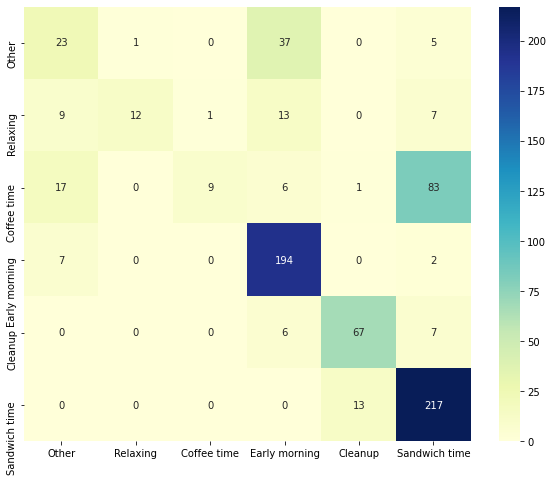

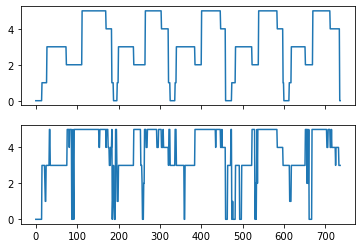

test subjects {2}
train subjects {1, 3, 4}
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')
Number of devices: 2
INFO:tensorflow:batch_all_reduce: 294 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 294 all-reduces with algorithm = nccl, num_packs = 1


In [ ]:
#no noise
run_experiment()

test subjects {4}
train subjects {1, 2, 3}
Epoch 1/50
37/37 - 32s - loss: 1.1875 - accuracy: 0.5492
Epoch 2/50
37/37 - 32s - loss: 0.5366 - accuracy: 0.8042
Epoch 3/50
37/37 - 33s - loss: 0.3414 - accuracy: 0.8740
Epoch 4/50
37/37 - 33s - loss: 0.3448 - accuracy: 0.8680
Epoch 5/50
37/37 - 33s - loss: 0.2734 - accuracy: 0.8953
Epoch 6/50
37/37 - 33s - loss: 0.2629 - accuracy: 0.9076
Epoch 7/50
37/37 - 33s - loss: 0.2148 - accuracy: 0.9229
Epoch 8/50
37/37 - 33s - loss: 0.3062 - accuracy: 0.8846
Epoch 9/50
37/37 - 33s - loss: 0.2272 - accuracy: 0.9200
Epoch 10/50
37/37 - 33s - loss: 0.1782 - accuracy: 0.9332
Epoch 11/50
37/37 - 33s - loss: 0.2661 - accuracy: 0.9008
Epoch 12/50
37/37 - 33s - loss: 0.2166 - accuracy: 0.9217
Epoch 13/50
37/37 - 33s - loss: 0.1610 - accuracy: 0.9413
Epoch 14/50
37/37 - 33s - loss: 0.1639 - accuracy: 0.9421
Epoch 15/50
37/37 - 33s - loss: 0.1855 - accuracy: 0.9357
Epoch 16/50
37/37 - 33s - loss: 0.1301 - accuracy: 0.9579
Epoch 17/50
37/37 - 33s - loss: 0.1216

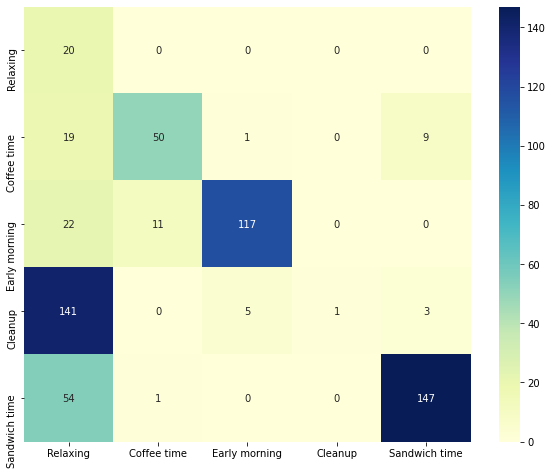

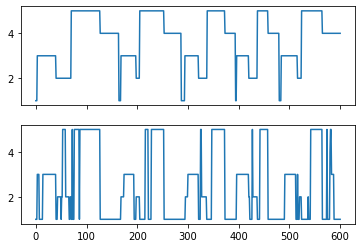

test subjects {3}
train subjects {1, 2, 4}
Epoch 1/50
36/36 - 31s - loss: 1.6517 - accuracy: 0.3178
Epoch 2/50
36/36 - 31s - loss: 1.2787 - accuracy: 0.4688
Epoch 3/50
36/36 - 31s - loss: 0.9598 - accuracy: 0.6335
Epoch 4/50
36/36 - 31s - loss: 0.8376 - accuracy: 0.6636
Epoch 5/50
36/36 - 31s - loss: 0.8804 - accuracy: 0.6445
Epoch 6/50
36/36 - 31s - loss: 0.8292 - accuracy: 0.6609
Epoch 7/50
36/36 - 31s - loss: 0.8754 - accuracy: 0.6507
Epoch 8/50
36/36 - 31s - loss: 0.8155 - accuracy: 0.6609
Epoch 9/50
36/36 - 31s - loss: 0.8415 - accuracy: 0.6529
Epoch 10/50
36/36 - 31s - loss: 0.9540 - accuracy: 0.6025
Epoch 11/50
36/36 - 31s - loss: 1.1949 - accuracy: 0.5060
Epoch 12/50
36/36 - 31s - loss: 1.0300 - accuracy: 0.5857
Epoch 13/50
36/36 - 31s - loss: 0.9130 - accuracy: 0.6060
Epoch 14/50
36/36 - 31s - loss: 0.9613 - accuracy: 0.5923
Epoch 15/50
36/36 - 31s - loss: 0.9866 - accuracy: 0.5901
Epoch 16/50
36/36 - 31s - loss: 0.9884 - accuracy: 0.5609
Epoch 17/50
36/36 - 31s - loss: 1.0476

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        62
           2       0.00      0.00      0.00       116
           3       0.00      0.00      0.00       203
           4       0.00      0.00      0.00        80
           5       0.33      1.00      0.50       230

    accuracy                           0.33       691
   macro avg       0.07      0.20      0.10       691
weighted avg       0.11      0.33      0.17       691



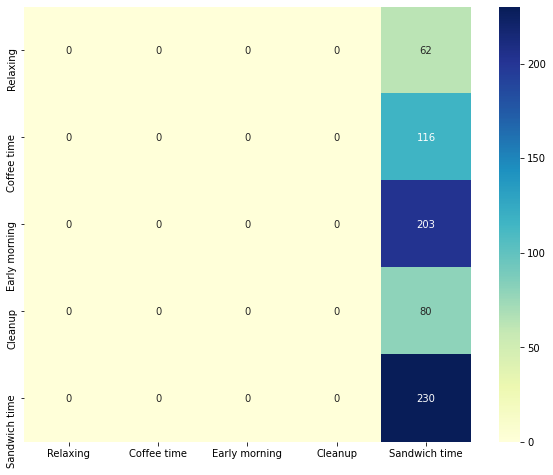

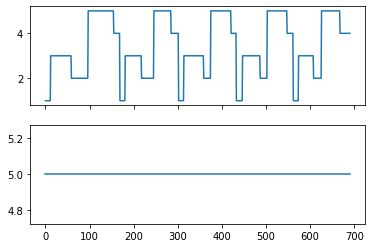

test subjects {2}
train subjects {1, 3, 4}
Epoch 1/50
34/34 - 30s - loss: 1.1845 - accuracy: 0.5077
Epoch 2/50
34/34 - 30s - loss: 0.6121 - accuracy: 0.7641
Epoch 3/50
34/34 - 30s - loss: 0.4353 - accuracy: 0.8266
Epoch 4/50
34/34 - 30s - loss: 0.3828 - accuracy: 0.8606
Epoch 5/50
34/34 - 30s - loss: 0.2862 - accuracy: 0.8993
Epoch 6/50
34/34 - 30s - loss: 0.2342 - accuracy: 0.9128
Epoch 7/50
34/34 - 30s - loss: 0.2730 - accuracy: 0.9035
Epoch 8/50
34/34 - 30s - loss: 0.2974 - accuracy: 0.8942
Epoch 9/50
34/34 - 30s - loss: 0.1984 - accuracy: 0.9389
Epoch 10/50
34/34 - 30s - loss: 0.3426 - accuracy: 0.8807
Epoch 11/50
34/34 - 30s - loss: 0.2355 - accuracy: 0.9203
Epoch 12/50
34/34 - 30s - loss: 0.2880 - accuracy: 0.8900
Epoch 13/50
34/34 - 30s - loss: 0.2380 - accuracy: 0.9170
Epoch 14/50
34/34 - 30s - loss: 0.3016 - accuracy: 0.8923
Epoch 15/50
34/34 - 30s - loss: 0.2991 - accuracy: 0.8918
Epoch 16/50
34/34 - 30s - loss: 0.2836 - accuracy: 0.9035
Epoch 17/50
34/34 - 30s - loss: 0.1815

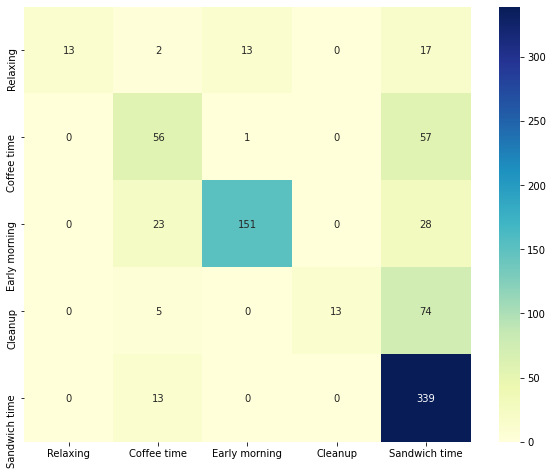

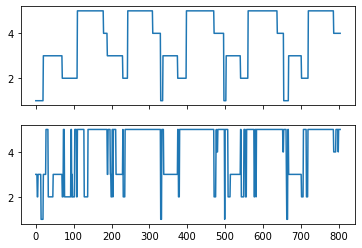

test subjects {1}
train subjects {2, 3, 4}
Epoch 1/50
33/33 - 29s - loss: 1.4200 - accuracy: 0.4338
Epoch 2/50
33/33 - 29s - loss: 0.8030 - accuracy: 0.6739
Epoch 3/50
33/33 - 29s - loss: 0.5253 - accuracy: 0.7916
Epoch 4/50
33/33 - 29s - loss: 0.4345 - accuracy: 0.8334
Epoch 5/50
33/33 - 29s - loss: 0.3085 - accuracy: 0.8923
Epoch 6/50
33/33 - 29s - loss: 0.3564 - accuracy: 0.8652
Epoch 7/50
33/33 - 29s - loss: 0.2613 - accuracy: 0.9079
Epoch 8/50
33/33 - 29s - loss: 0.2347 - accuracy: 0.9131
Epoch 9/50
33/33 - 29s - loss: 0.2252 - accuracy: 0.9155
Epoch 10/50
33/33 - 29s - loss: 0.3122 - accuracy: 0.8880
Epoch 11/50
33/33 - 29s - loss: 0.2306 - accuracy: 0.9136
Epoch 12/50
33/33 - 29s - loss: 0.3164 - accuracy: 0.8813
Epoch 13/50
33/33 - 29s - loss: 0.2630 - accuracy: 0.9060
Epoch 14/50
33/33 - 29s - loss: 0.2199 - accuracy: 0.9160
Epoch 15/50
33/33 - 29s - loss: 0.2212 - accuracy: 0.9150
Epoch 16/50
33/33 - 29s - loss: 0.2104 - accuracy: 0.9217
Epoch 17/50
33/33 - 29s - loss: 0.3850

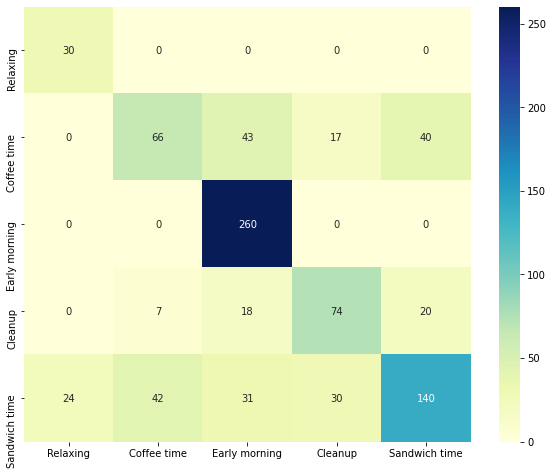

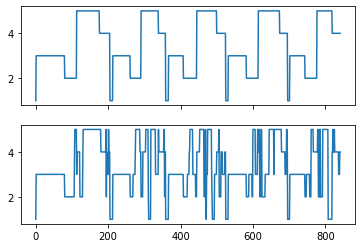

In [ ]:
run_experiment(no_null_class=True)

test subjects {4}
train subjects {1, 2, 3}
Epoch 1/30
19/19 - 16s - loss: 1.7411 - accuracy: 0.3061
Epoch 2/30
19/19 - 16s - loss: 1.4682 - accuracy: 0.4032
Epoch 3/30
19/19 - 16s - loss: 1.0112 - accuracy: 0.6198
Epoch 4/30
19/19 - 15s - loss: 0.9465 - accuracy: 0.6083
Epoch 5/30
19/19 - 16s - loss: 0.8542 - accuracy: 0.6539
Epoch 6/30
19/19 - 16s - loss: 0.7855 - accuracy: 0.6709
Epoch 7/30
19/19 - 16s - loss: 0.6846 - accuracy: 0.7118
Epoch 8/30
19/19 - 16s - loss: 0.5204 - accuracy: 0.7940
Epoch 9/30
19/19 - 15s - loss: 0.3633 - accuracy: 0.8680
Epoch 10/30
19/19 - 16s - loss: 0.2942 - accuracy: 0.8940
Epoch 11/30
19/19 - 16s - loss: 0.2931 - accuracy: 0.8995
Epoch 12/30
19/19 - 16s - loss: 0.2465 - accuracy: 0.9157
Epoch 13/30
19/19 - 16s - loss: 0.1712 - accuracy: 0.9383
Epoch 14/30
19/19 - 16s - loss: 0.1847 - accuracy: 0.9332
Epoch 15/30
19/19 - 16s - loss: 0.2324 - accuracy: 0.9166
Epoch 16/30
19/19 - 16s - loss: 0.1890 - accuracy: 0.9366
Epoch 17/30
19/19 - 16s - loss: 0.1627

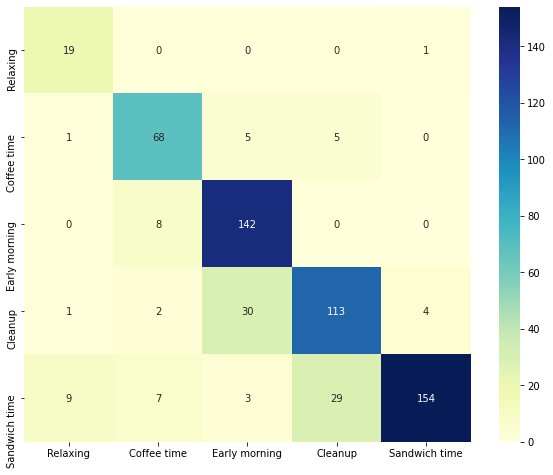

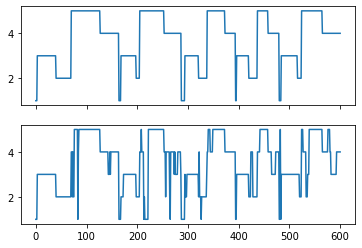

test subjects {3}
train subjects {1, 2, 4}
Epoch 1/30
18/18 - 15s - loss: 1.4926 - accuracy: 0.4006
Epoch 2/30
18/18 - 15s - loss: 1.0201 - accuracy: 0.6003
Epoch 3/30
18/18 - 15s - loss: 0.9240 - accuracy: 0.6313
Epoch 4/30
18/18 - 15s - loss: 0.7676 - accuracy: 0.6941
Epoch 5/30
18/18 - 15s - loss: 0.5515 - accuracy: 0.7694
Epoch 6/30
18/18 - 15s - loss: 0.4174 - accuracy: 0.8442
Epoch 7/30
18/18 - 15s - loss: 0.3296 - accuracy: 0.8756
Epoch 8/30
18/18 - 15s - loss: 0.2978 - accuracy: 0.8884
Epoch 9/30
18/18 - 15s - loss: 0.2216 - accuracy: 0.9265
Epoch 10/30
18/18 - 15s - loss: 0.2258 - accuracy: 0.9239
Epoch 11/30
18/18 - 15s - loss: 0.2052 - accuracy: 0.9287
Epoch 12/30
18/18 - 15s - loss: 0.1546 - accuracy: 0.9504
Epoch 13/30
18/18 - 15s - loss: 0.1329 - accuracy: 0.9566
Epoch 14/30
18/18 - 15s - loss: 0.1894 - accuracy: 0.9398
Epoch 15/30
18/18 - 15s - loss: 0.1992 - accuracy: 0.9314
Epoch 16/30
18/18 - 15s - loss: 0.2897 - accuracy: 0.9008
Epoch 17/30
18/18 - 15s - loss: 0.1834

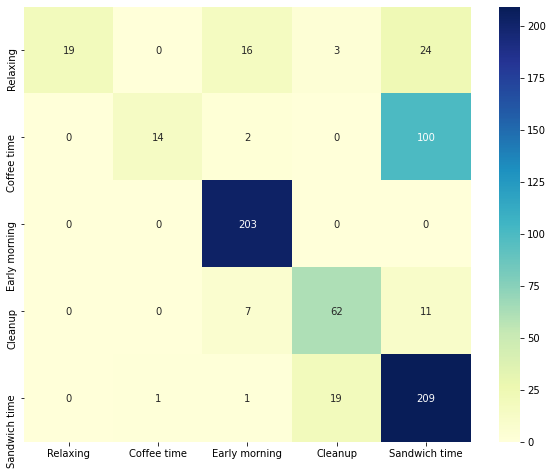

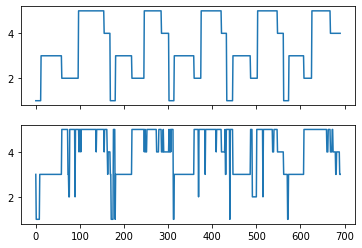

test subjects {2}
train subjects {1, 3, 4}
Epoch 1/30
17/17 - 14s - loss: 1.6442 - accuracy: 0.3641
Epoch 2/30
17/17 - 14s - loss: 1.0184 - accuracy: 0.5953
Epoch 3/30
17/17 - 14s - loss: 0.9247 - accuracy: 0.6093
Epoch 4/30
17/17 - 14s - loss: 0.8638 - accuracy: 0.6424
Epoch 5/30
17/17 - 14s - loss: 0.7973 - accuracy: 0.6793
Epoch 6/30
17/17 - 14s - loss: 0.7001 - accuracy: 0.7198
Epoch 7/30
17/17 - 14s - loss: 0.5914 - accuracy: 0.7515
Epoch 8/30
17/17 - 14s - loss: 0.4301 - accuracy: 0.8438
Epoch 9/30
17/17 - 14s - loss: 0.4341 - accuracy: 0.8434
Epoch 10/30
17/17 - 14s - loss: 0.4335 - accuracy: 0.8392
Epoch 11/30
17/17 - 14s - loss: 0.4276 - accuracy: 0.8350
Epoch 12/30
17/17 - 14s - loss: 0.3656 - accuracy: 0.8536
Epoch 13/30
17/17 - 14s - loss: 0.3123 - accuracy: 0.8779
Epoch 14/30
17/17 - 14s - loss: 0.2623 - accuracy: 0.9026
Epoch 15/30
17/17 - 14s - loss: 0.2504 - accuracy: 0.9072
Epoch 16/30
17/17 - 14s - loss: 0.2372 - accuracy: 0.9054
Epoch 17/30
17/17 - 14s - loss: 0.2941

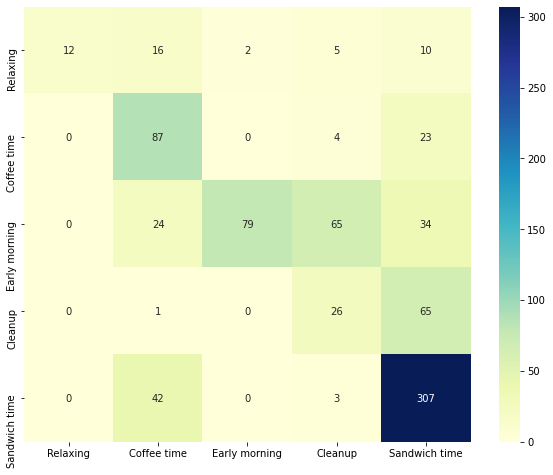

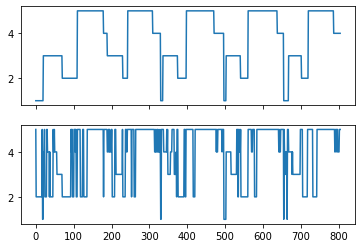

test subjects {1}
train subjects {2, 3, 4}
Epoch 1/30
17/17 - 14s - loss: 1.6656 - accuracy: 0.3213
Epoch 2/30
17/17 - 14s - loss: 1.1347 - accuracy: 0.5918
Epoch 3/30
17/17 - 14s - loss: 0.7660 - accuracy: 0.7176
Epoch 4/30
17/17 - 14s - loss: 0.5705 - accuracy: 0.7921
Epoch 5/30
17/17 - 14s - loss: 0.3907 - accuracy: 0.8491
Epoch 6/30
17/17 - 14s - loss: 0.3437 - accuracy: 0.8766
Epoch 7/30
17/17 - 14s - loss: 0.2480 - accuracy: 0.9084
Epoch 8/30
Epoch 9/30
17/17 - 14s - loss: 0.2555 - accuracy: 0.9079
Epoch 10/30
17/17 - 14s - loss: 0.3278 - accuracy: 0.8837
Epoch 11/30
17/17 - 14s - loss: 0.1845 - accuracy: 0.9317
Epoch 12/30
17/17 - 14s - loss: 0.1770 - accuracy: 0.9407
Epoch 13/30
17/17 - 14s - loss: 0.2987 - accuracy: 0.8842
Epoch 14/30
17/17 - 14s - loss: 0.2001 - accuracy: 0.9293
Epoch 15/30
17/17 - 14s - loss: 0.1975 - accuracy: 0.9298
Epoch 16/30
17/17 - 14s - loss: 0.1319 - accuracy: 0.9559
Epoch 17/30
17/17 - 14s - loss: 0.2648 - accuracy: 0.9136
Epoch 18/30
17/17 - 14s - 

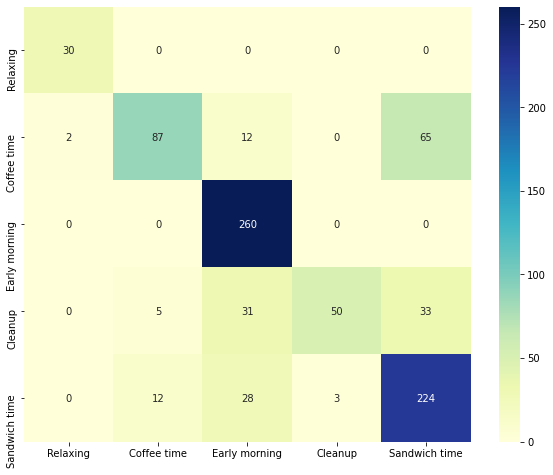

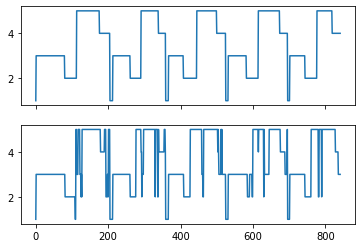

In [ ]:
run_experiment(no_null_class=True)

test subjects {4}
train subjects {1, 2, 3}
Epoch 1/60
37/37 - 7s - loss: 1.4734 - accuracy: 0.4261
Epoch 2/60
37/37 - 7s - loss: 0.8374 - accuracy: 0.6594
Epoch 3/60
37/37 - 7s - loss: 0.5016 - accuracy: 0.8140
Epoch 4/60
37/37 - 7s - loss: 0.4490 - accuracy: 0.8335
Epoch 5/60
37/37 - 7s - loss: 0.3061 - accuracy: 0.8825
Epoch 6/60
37/37 - 7s - loss: 0.4491 - accuracy: 0.8421
Epoch 7/60
37/37 - 7s - loss: 0.3903 - accuracy: 0.8484
Epoch 8/60
37/37 - 7s - loss: 0.3010 - accuracy: 0.8825
Epoch 9/60
37/37 - 7s - loss: 0.2555 - accuracy: 0.8995
Epoch 10/60
37/37 - 7s - loss: 0.2903 - accuracy: 0.8957
Epoch 11/60
37/37 - 7s - loss: 0.2858 - accuracy: 0.8868
Epoch 12/60
37/37 - 7s - loss: 0.2297 - accuracy: 0.9123
Epoch 13/60
37/37 - 7s - loss: 0.2399 - accuracy: 0.9106
Epoch 14/60
37/37 - 7s - loss: 0.2305 - accuracy: 0.9191
Epoch 15/60
37/37 - 7s - loss: 0.3316 - accuracy: 0.8855
Epoch 16/60
37/37 - 7s - loss: 0.3399 - accuracy: 0.8821
Epoch 17/60
37/37 - 7s - loss: 0.3376 - accuracy: 0.88

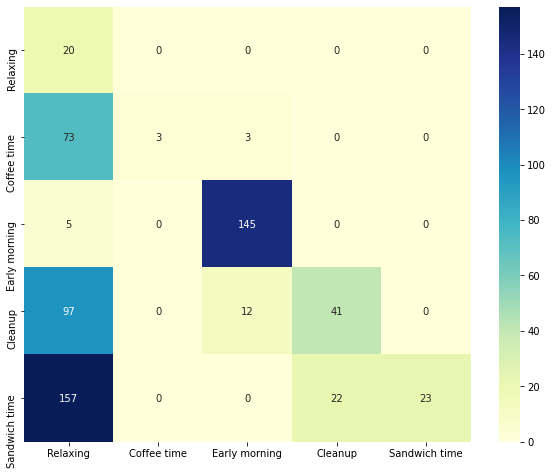

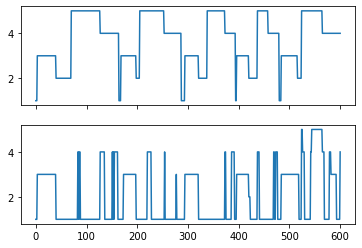

test subjects {3}
train subjects {1, 2, 4}
Epoch 1/60
36/36 - 7s - loss: 1.5130 - accuracy: 0.3851
Epoch 2/60
36/36 - 7s - loss: 0.8022 - accuracy: 0.6848
Epoch 3/60
36/36 - 7s - loss: 0.4454 - accuracy: 0.8203
Epoch 4/60
36/36 - 7s - loss: 0.4103 - accuracy: 0.8459
Epoch 5/60
36/36 - 7s - loss: 0.3377 - accuracy: 0.8668
Epoch 6/60
36/36 - 7s - loss: 0.3361 - accuracy: 0.8796
Epoch 7/60
36/36 - 7s - loss: 0.2922 - accuracy: 0.8929
Epoch 8/60
36/36 - 7s - loss: 0.2909 - accuracy: 0.8915
Epoch 9/60
36/36 - 7s - loss: 0.3110 - accuracy: 0.8884
Epoch 10/60
36/36 - 7s - loss: 0.6013 - accuracy: 0.7946
Epoch 11/60
36/36 - 7s - loss: 0.4059 - accuracy: 0.8530
Epoch 12/60
36/36 - 7s - loss: 0.2491 - accuracy: 0.9031
Epoch 13/60
36/36 - 7s - loss: 0.2372 - accuracy: 0.9132
Epoch 14/60
36/36 - 7s - loss: 0.2299 - accuracy: 0.9146
Epoch 15/60
36/36 - 7s - loss: 0.1788 - accuracy: 0.9367
Epoch 16/60
36/36 - 7s - loss: 0.1861 - accuracy: 0.9402
Epoch 17/60
36/36 - 7s - loss: 0.1539 - accuracy: 0.94

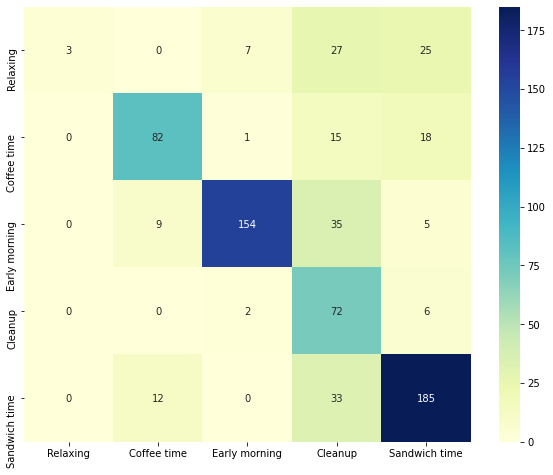

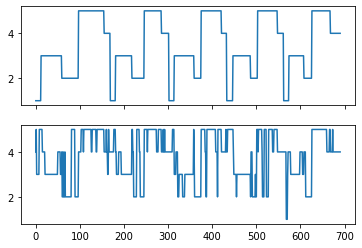

test subjects {2}
train subjects {1, 3, 4}
Epoch 1/60
34/34 - 6s - loss: 1.5221 - accuracy: 0.4000
Epoch 2/60
34/34 - 6s - loss: 0.9334 - accuracy: 0.6093
Epoch 3/60
34/34 - 6s - loss: 0.7611 - accuracy: 0.6769
Epoch 4/60
34/34 - 6s - loss: 0.5193 - accuracy: 0.7837
Epoch 5/60
34/34 - 6s - loss: 0.4255 - accuracy: 0.8457
Epoch 6/60
34/34 - 6s - loss: 0.3294 - accuracy: 0.8909
Epoch 7/60
34/34 - 6s - loss: 0.3197 - accuracy: 0.8881
Epoch 8/60
34/34 - 6s - loss: 0.2574 - accuracy: 0.9105
Epoch 9/60
34/34 - 6s - loss: 0.2497 - accuracy: 0.9133
Epoch 10/60
34/34 - 6s - loss: 0.2423 - accuracy: 0.9138
Epoch 11/60
34/34 - 6s - loss: 0.1775 - accuracy: 0.9478
Epoch 12/60
34/34 - 6s - loss: 0.1688 - accuracy: 0.9441
Epoch 13/60
34/34 - 6s - loss: 0.4113 - accuracy: 0.8653
Epoch 14/60
34/34 - 6s - loss: 0.2917 - accuracy: 0.9044
Epoch 15/60
34/34 - 6s - loss: 0.2781 - accuracy: 0.9016
Epoch 16/60
34/34 - 6s - loss: 0.2315 - accuracy: 0.9315
Epoch 17/60
34/34 - 6s - loss: 0.1503 - accuracy: 0.95

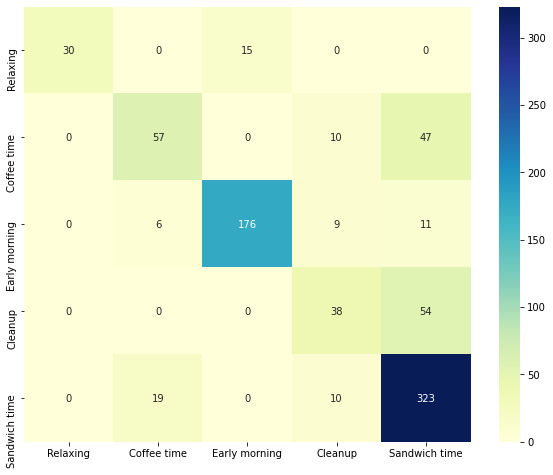

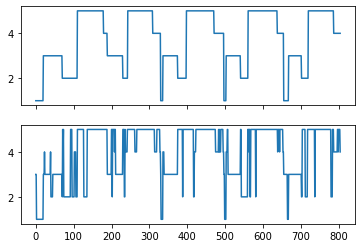

test subjects {1}
train subjects {2, 3, 4}
Epoch 1/60
33/33 - 6s - loss: 1.3845 - accuracy: 0.4570
Epoch 2/60
33/33 - 6s - loss: 0.9431 - accuracy: 0.6360
Epoch 3/60
33/33 - 6s - loss: 0.7920 - accuracy: 0.6792
Epoch 4/60
33/33 - 6s - loss: 0.6803 - accuracy: 0.7219
Epoch 5/60
33/33 - 6s - loss: 0.5384 - accuracy: 0.7712
Epoch 6/60
33/33 - 6s - loss: 0.5433 - accuracy: 0.7822
Epoch 7/60
33/33 - 6s - loss: 0.4706 - accuracy: 0.8234
Epoch 8/60
33/33 - 6s - loss: 0.3503 - accuracy: 0.8628
Epoch 9/60
33/33 - 6s - loss: 0.2933 - accuracy: 0.8847
Epoch 10/60
33/33 - 6s - loss: 0.2706 - accuracy: 0.8932
Epoch 11/60
33/33 - 6s - loss: 0.2829 - accuracy: 0.8875
Epoch 12/60
33/33 - 6s - loss: 0.2747 - accuracy: 0.8961
Epoch 13/60
33/33 - 6s - loss: 0.1865 - accuracy: 0.9317
Epoch 14/60
33/33 - 6s - loss: 0.1361 - accuracy: 0.9497
Epoch 15/60
33/33 - 6s - loss: 0.2614 - accuracy: 0.9093
Epoch 16/60
33/33 - 6s - loss: 0.2501 - accuracy: 0.9103
Epoch 17/60
33/33 - 6s - loss: 0.1710 - accuracy: 0.93

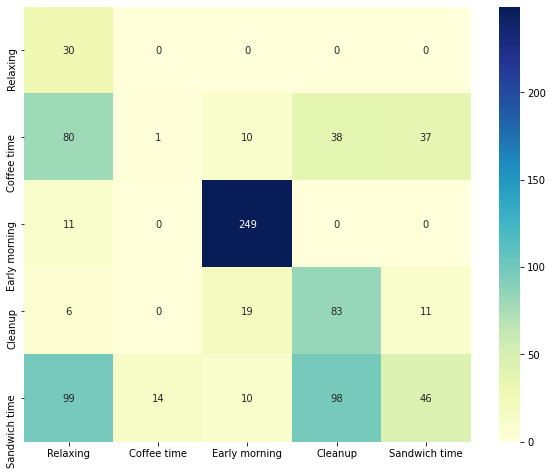

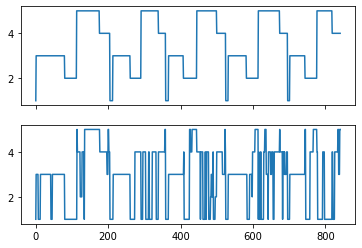

In [28]:
run_experiment(BATCH_SIZE =64, no_null_class=True)

test subjects {4}
train subjects {1, 2, 3}
Epoch 1/60
74/74 - 8s - loss: 0.9520 - accuracy: 0.6343
Epoch 2/60
74/74 - 8s - loss: 0.5191 - accuracy: 0.8114
Epoch 3/60
74/74 - 8s - loss: 0.4749 - accuracy: 0.8238
Epoch 4/60
74/74 - 8s - loss: 0.4191 - accuracy: 0.8404
Epoch 5/60
74/74 - 8s - loss: 0.3698 - accuracy: 0.8548
Epoch 6/60
74/74 - 8s - loss: 0.3830 - accuracy: 0.8480
Epoch 7/60
74/74 - 8s - loss: 0.4097 - accuracy: 0.8365
Epoch 8/60
74/74 - 8s - loss: 0.3410 - accuracy: 0.8672
Epoch 9/60
74/74 - 8s - loss: 0.4294 - accuracy: 0.8408
Epoch 10/60
74/74 - 8s - loss: 0.4515 - accuracy: 0.8301
Epoch 11/60
74/74 - 8s - loss: 0.3695 - accuracy: 0.8616
Epoch 12/60
74/74 - 8s - loss: 0.3154 - accuracy: 0.8817
Epoch 13/60
74/74 - 8s - loss: 0.3115 - accuracy: 0.8787
Epoch 14/60
74/74 - 8s - loss: 0.3090 - accuracy: 0.8791
Epoch 15/60
74/74 - 8s - loss: 0.3600 - accuracy: 0.8736
Epoch 16/60
74/74 - 8s - loss: 0.3998 - accuracy: 0.8544
Epoch 17/60
74/74 - 8s - loss: 0.2658 - accuracy: 0.89

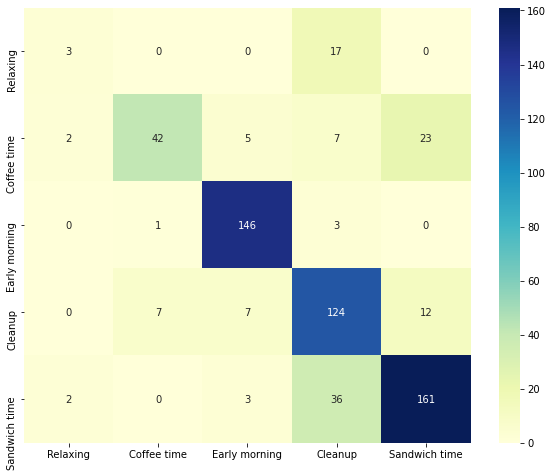

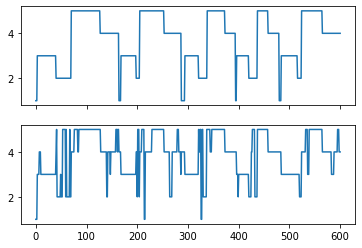

test subjects {3}
train subjects {1, 2, 4}
Epoch 1/60
71/71 - 7s - loss: 1.1758 - accuracy: 0.5374
Epoch 2/60
71/71 - 7s - loss: 0.7831 - accuracy: 0.6773
Epoch 3/60
71/71 - 7s - loss: 0.6789 - accuracy: 0.7410
Epoch 4/60
71/71 - 7s - loss: 0.4854 - accuracy: 0.8070
Epoch 5/60
71/71 - 7s - loss: 0.5043 - accuracy: 0.8172
Epoch 6/60
71/71 - 7s - loss: 0.5863 - accuracy: 0.7813
Epoch 7/60
71/71 - 7s - loss: 0.5091 - accuracy: 0.8088
Epoch 8/60
71/71 - 7s - loss: 0.5043 - accuracy: 0.8088
Epoch 9/60
71/71 - 7s - loss: 0.4134 - accuracy: 0.8420
Epoch 10/60
71/71 - 7s - loss: 0.3715 - accuracy: 0.8610
Epoch 11/60
71/71 - 7s - loss: 0.3647 - accuracy: 0.8544
Epoch 12/60
71/71 - 7s - loss: 0.4094 - accuracy: 0.8499
Epoch 13/60
71/71 - 7s - loss: 0.3773 - accuracy: 0.8539
Epoch 14/60
71/71 - 7s - loss: 0.3390 - accuracy: 0.8694
Epoch 15/60
71/71 - 7s - loss: 0.3732 - accuracy: 0.8539
Epoch 16/60
71/71 - 7s - loss: 0.4054 - accuracy: 0.8442
Epoch 17/60
71/71 - 7s - loss: 0.3407 - accuracy: 0.86

/home/agency/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


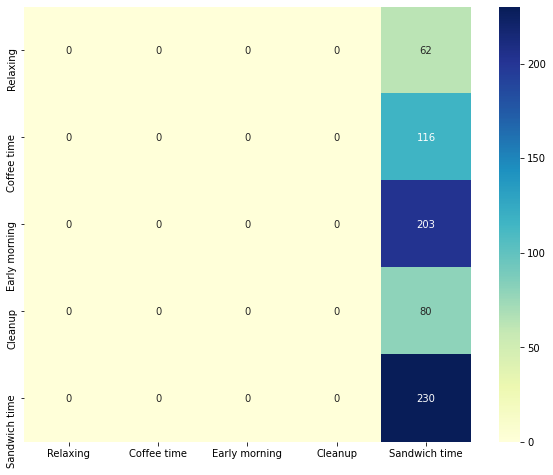

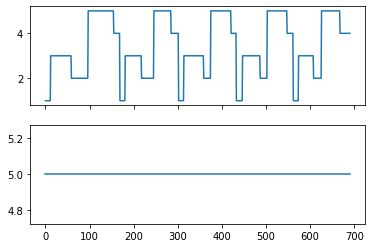

test subjects {2}
train subjects {1, 3, 4}
Epoch 1/60
68/68 - 7s - loss: 1.3197 - accuracy: 0.4783
Epoch 2/60
68/68 - 7s - loss: 1.0338 - accuracy: 0.5688
Epoch 3/60
68/68 - 7s - loss: 0.8796 - accuracy: 0.6205
Epoch 4/60
68/68 - 7s - loss: 0.8986 - accuracy: 0.6275
Epoch 5/60
68/68 - 7s - loss: 0.8105 - accuracy: 0.6639
Epoch 6/60
68/68 - 7s - loss: 0.6006 - accuracy: 0.7650
Epoch 7/60
68/68 - 7s - loss: 0.5628 - accuracy: 0.7893
Epoch 8/60
68/68 - 7s - loss: 0.6537 - accuracy: 0.7492
Epoch 9/60
68/68 - 7s - loss: 0.4964 - accuracy: 0.8121
Epoch 10/60
68/68 - 7s - loss: 0.5925 - accuracy: 0.7804
Epoch 11/60
68/68 - 7s - loss: 0.8333 - accuracy: 0.6970
Epoch 12/60
68/68 - 7s - loss: 0.7260 - accuracy: 0.7161
Epoch 13/60
68/68 - 7s - loss: 0.6593 - accuracy: 0.7399
Epoch 14/60
68/68 - 7s - loss: 0.7189 - accuracy: 0.7268
Epoch 15/60
68/68 - 7s - loss: 0.6777 - accuracy: 0.7259
Epoch 16/60
68/68 - 7s - loss: 0.5377 - accuracy: 0.7986
Epoch 17/60
68/68 - 7s - loss: 0.5167 - accuracy: 0.79

/home/agency/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


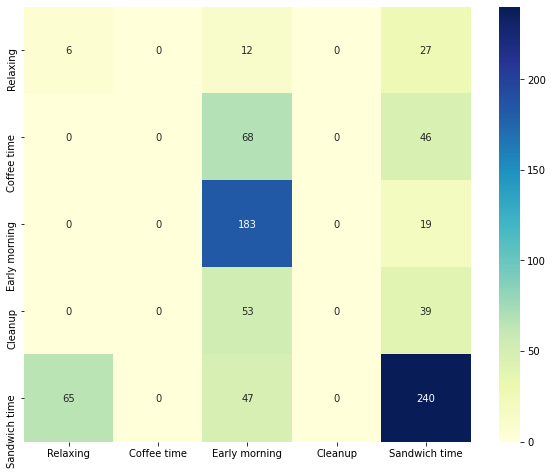

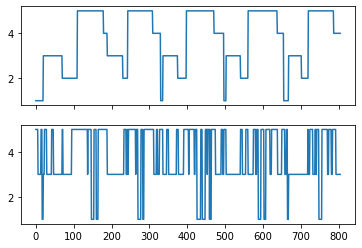

test subjects {1}
train subjects {2, 3, 4}
Epoch 1/60
66/66 - 7s - loss: 1.3564 - accuracy: 0.4623
Epoch 2/60
66/66 - 7s - loss: 0.8195 - accuracy: 0.6602
Epoch 3/60
66/66 - 7s - loss: 0.6240 - accuracy: 0.7442
Epoch 4/60
66/66 - 7s - loss: 0.6992 - accuracy: 0.7091
Epoch 5/60
66/66 - 7s - loss: 0.7136 - accuracy: 0.6953
Epoch 6/60
66/66 - 7s - loss: 0.6553 - accuracy: 0.7110
Epoch 7/60
66/66 - 7s - loss: 0.7461 - accuracy: 0.6801
Epoch 8/60
66/66 - 7s - loss: 0.6130 - accuracy: 0.7404
Epoch 9/60
66/66 - 7s - loss: 0.6059 - accuracy: 0.7337
Epoch 10/60
66/66 - 7s - loss: 0.5272 - accuracy: 0.7774
Epoch 11/60
66/66 - 7s - loss: 0.5371 - accuracy: 0.7822
Epoch 12/60
66/66 - 7s - loss: 0.6112 - accuracy: 0.7399
Epoch 13/60
66/66 - 7s - loss: 0.5776 - accuracy: 0.7670
Epoch 14/60
66/66 - 7s - loss: 0.4992 - accuracy: 0.7973
Epoch 15/60
66/66 - 7s - loss: 0.5360 - accuracy: 0.7897
Epoch 16/60
66/66 - 7s - loss: 0.4443 - accuracy: 0.8310
Epoch 17/60
66/66 - 7s - loss: 0.3916 - accuracy: 0.84

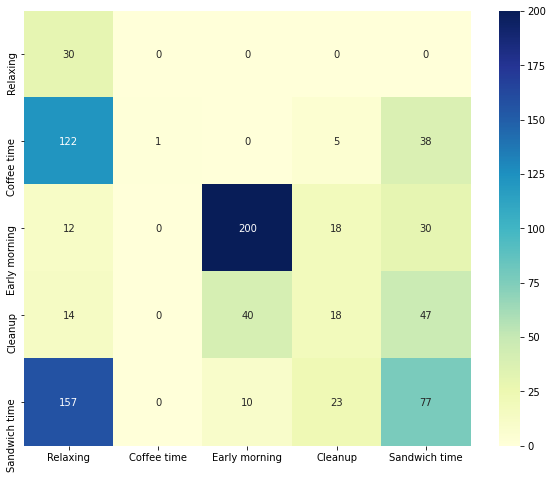

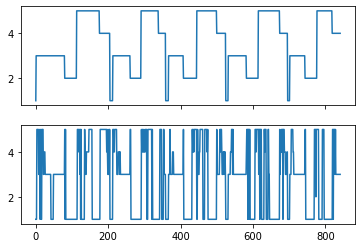

In [29]:
run_experiment(BATCH_SIZE =32, no_null_class=True)

test subjects {4}
train subjects {1, 2, 3}
              precision    recall  f1-score   support

           0       0.71      0.93      0.80       141
           1       0.33      0.40      0.36         5
           2       1.00      0.03      0.05        79
           3       0.81      1.00      0.89       150
           4       0.96      0.73      0.83       150
           5       0.80      0.93      0.86       202

    accuracy                           0.80       727
   macro avg       0.77      0.67      0.63       727
weighted avg       0.83      0.80      0.76       727



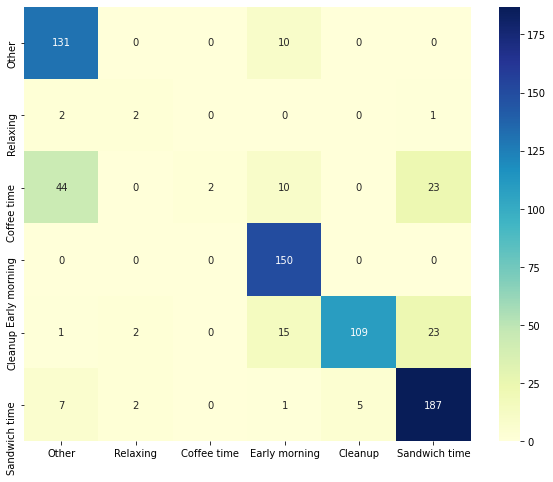

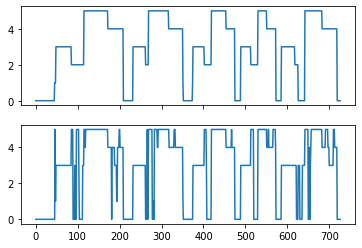

test subjects {3}
train subjects {1, 2, 4}
              precision    recall  f1-score   support

           0       0.59      0.15      0.24        66
           1       1.00      0.02      0.05        42
           2       0.58      0.62      0.60       116
           3       0.79      0.87      0.83       203
           4       0.65      0.95      0.77        80
           5       0.76      0.84      0.80       230

    accuracy                           0.72       737
   macro avg       0.73      0.58      0.55       737
weighted avg       0.73      0.72      0.68       737



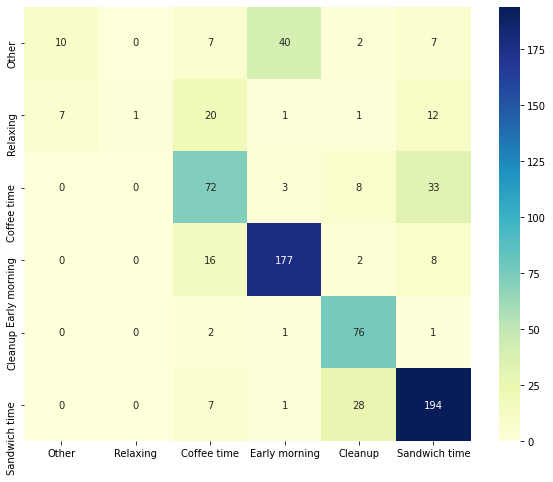

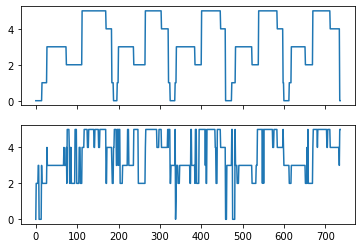

test subjects {2}
train subjects {1, 3, 4}
              precision    recall  f1-score   support

           0       0.69      0.91      0.78        80
           1       1.00      0.23      0.37        31
           2       0.67      0.77      0.72       114
           3       0.99      0.73      0.84       202
           4       0.36      0.69      0.47        87
           5       0.88      0.77      0.82       347

    accuracy                           0.75       861
   macro avg       0.77      0.68      0.67       861
weighted avg       0.81      0.75      0.76       861



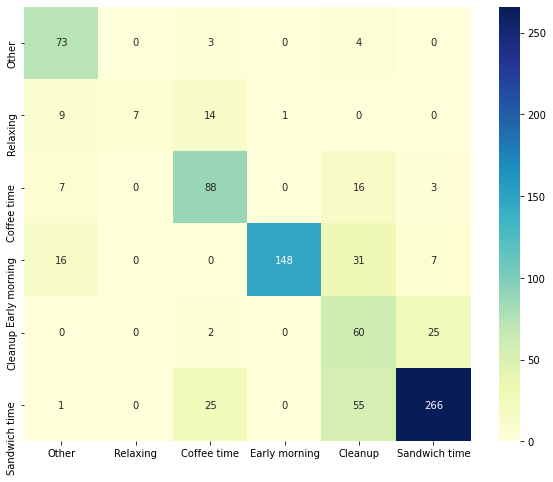

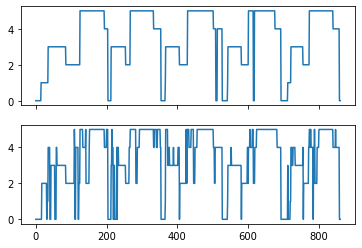

test subjects {1}
train subjects {2, 3, 4}
              precision    recall  f1-score   support

           0       0.98      0.73      0.83       128
           1       0.38      1.00      0.55         8
           2       0.88      0.31      0.46       166
           3       0.61      0.99      0.76       260
           4       0.61      0.86      0.71       119
           5       0.70      0.48      0.57       267

    accuracy                           0.68       948
   macro avg       0.69      0.73      0.65       948
weighted avg       0.73      0.68      0.65       948



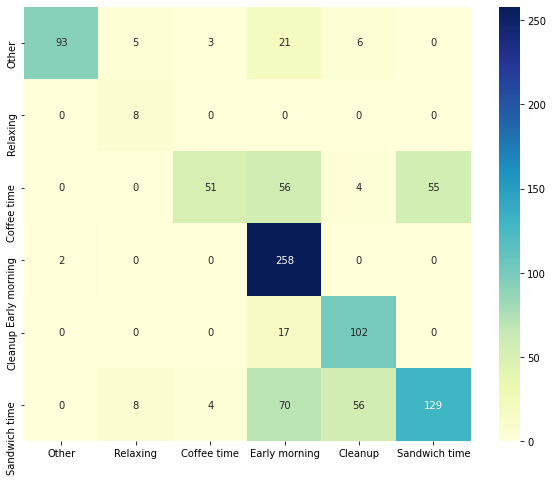

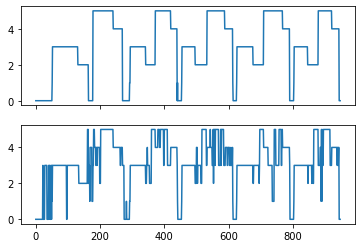

In [ ]:
run_experiment()

In [ ]:
['BACK', 'RUA', 'RLA', 'LUA', 'LLA', 'L-SHOE', 'R-SHOE']

## Attention maps

In [ ]:
np.save('opp_benm_preds.npy', np.argmax(pred, axis=1))

In [ ]:
['BACK', 'RUA', 'RLA', 'LUA', 'LLA', 'L-SHOE', 'R-SHOE']

['BACK', 'RUA', 'RLA', 'LUA', 'LLA', 'L-SHOE', 'R-SHOE']

In [ ]:
window_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("multi_window_encoder").output)
session_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("combined_sensor_self_attention_1").output)

In [ ]:
_, w_out = window_model.predict(X_test)
_, s_out = session_model.predict(X_test)

In [ ]:
np.save('opp_benm_window.npy', w_out)
np.save('opp_benm_session.npy', s_out)

In [ ]:
idx = 97
example = X_test[idx]
example = example[np.newaxis, :]
_, aa1 = window_model.predict(example)
_, aa2 = session_model.predict(example)

In [ ]:
aa1.shape

(1, 252, 25)

In [ ]:
aa2.shape

(1, 1, 36)

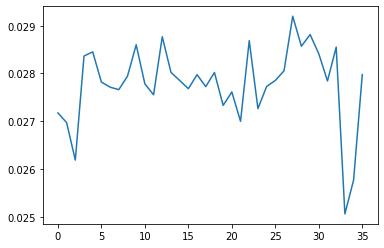

In [ ]:
plt.plot(aa2.flatten())